In [21]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from pydub import AudioSegment
from pydub.silence import split_on_silence
from scipy.ndimage import median_filter

# Define paths
input_base_path = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar'
output_base_path = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1'
spectrogram_output_base_path = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\CONVERTED1'

folders = ['HC', 'PD']  # Healthy Control and Parkinson's Disease
types = ['chroma', 'cqt', 'mel', 'mfcc', 'stft']  # Types of spectrograms to generate

# VAD segmentation parameters
vad_window_size = 0.02  # 20 ms window
merge_distance = 0.25  # 250 ms merge threshold
threshold_factor = 0.7  # Adjusted threshold factor

# Minimum segment duration in samples (e.g., 1 second)
min_segment_samples = int(1 * 44100)  # 44.1 kHz sample rate

# Helper function for short-term energy and spectral spread
def compute_energy_spread(y, sr, frame_length=2048, hop_length=512):
    st_energy = np.array([sum(abs(y[i:i+frame_length])**2) for i in range(0, len(y), hop_length)])
    st_energy = median_filter(st_energy, size=5)  # Apply median filter to smooth energy
    
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    spectral_spread = np.sqrt(np.mean((spectral_centroids - np.mean(spectral_centroids))**2))
    spectral_spread = median_filter(spectral_spread, size=5)  # Apply median filter to smooth spread
    
    return st_energy, spectral_spread

# Function to apply VAD and segment audio
def vad_segmentation(y, sr, st_energy, spectral_spread, threshold_factor=0.5):
    speech_segments = []
    
    # Calculate threshold values
    energy_threshold = np.percentile(st_energy, 30) * threshold_factor
    spread_threshold = np.percentile(spectral_spread, 30) * threshold_factor
    print(f"Energy threshold: {energy_threshold}, Spread threshold: {spread_threshold}")
    
    is_speech = (st_energy > energy_threshold) & (spectral_spread > spread_threshold)
    current_segment = []
    
    for i, frame in enumerate(is_speech):
        if frame:
            current_segment.append(i)
        elif current_segment:
            if len(speech_segments) > 0 and (i - speech_segments[-1][-1] <= int(merge_distance * sr / (vad_window_size * sr))):
                speech_segments[-1].extend(current_segment)
            else:
                if len(current_segment) * int(sr * vad_window_size) >= min_segment_samples:
                    speech_segments.append(current_segment)
            current_segment = []
    
    if not speech_segments:
        print("No segments found after applying thresholds.")
    return speech_segments

# Function to clean audio (noise reduction and silence removal)
def clean_audio(file_path, output_path, silence_thresh=-25, min_silence_len=1000):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=None)

        # Noise reduction: Remove background noise
        noise_sample = y[:sr]  # Use the first second as noise sample
        noise_profile = np.mean(np.abs(noise_sample)) * 1.2  # Adjust threshold
        y_cleaned = np.where(np.abs(y) > noise_profile, y, 0)

        # Convert to Pydub AudioSegment for silence removal
        audio_segment = AudioSegment(
            y_cleaned.tobytes(),
            frame_rate=sr,
            sample_width=y_cleaned.dtype.itemsize,
            channels=1
        )

        # Remove silence
        chunks = split_on_silence(
            audio_segment,
            min_silence_len=min_silence_len,  # Minimum silence length (ms)
            silence_thresh=silence_thresh  # Silence threshold (dB)
        )

        # Combine non-silent chunks
        cleaned_audio = AudioSegment.empty()
        for chunk in chunks:
            cleaned_audio += chunk

        # Export cleaned audio
        cleaned_audio.export(output_path, format="wav")
        print(f"Cleaned audio saved to {output_path}")

        return y_cleaned, sr

    except Exception as e:
        print(f"Error cleaning {file_path}: {e}")
        return None, None

# Function to save spectrogram as image
def save_spectrogram(y_segment, sr, img_type, category_folder, filename):
    plt.figure(figsize=(6, 6))
    if img_type == 'chroma':
        chroma = librosa.feature.chroma_stft(y=y_segment, sr=sr)
        librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='viridis')
    elif img_type == 'cqt':
        cqt = librosa.amplitude_to_db(np.abs(librosa.cqt(y_segment, sr=sr)), ref=np.max)
        librosa.display.specshow(cqt, sr=sr, x_axis='time', y_axis='cqt_note', cmap='viridis')
    elif img_type == 'mel':
        mel = librosa.feature.melspectrogram(y=y_segment, sr=sr)
        mel_db = librosa.power_to_db(mel, ref=np.max)  # Convert to decibel scale
        librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    elif img_type == 'mfcc':
        mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
        librosa.display.specshow(mfcc, x_axis='time', cmap='viridis')
    elif img_type == 'stft':
        n_fft = min(2048, len(y_segment) // 2)  # Dynamic n_fft based on segment length
        stft = librosa.amplitude_to_db(np.abs(librosa.stft(y_segment, n_fft=n_fft)), ref=np.max)
        librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    else:
        return

    plt.axis('off')  # Remove padding and titles
    output_img_path = os.path.join(category_folder, f"{filename}.png")
    plt.savefig(output_img_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Process each audio file
for category in folders:
    input_folder = os.path.join(input_base_path, category)
    output_folder = os.path.join(output_base_path, category)
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.endswith(".wav"):
            input_file = os.path.join(input_folder, filename)
            output_file = os.path.join(output_folder, filename)

            # Clean the audio
            y_cleaned, sr = clean_audio(input_file, output_file)
            if y_cleaned is None or sr is None:
                continue  # Skip if cleaning failed

            # Compute energy and spectral spread for VAD
            st_energy, spectral_spread = compute_energy_spread(y_cleaned, sr)

            # Apply VAD and obtain speech segments
            speech_segments = vad_segmentation(y_cleaned, sr, st_energy, spectral_spread, threshold_factor)

            if not speech_segments:
                print(f"No speech segments found for {filename}")
                continue

            print(f"Found {len(speech_segments)} segments for {filename}")

            # Save each segment in each spectrogram type folder
            for idx, segment_indices in enumerate(speech_segments):
                start = segment_indices[0] * int(sr * vad_window_size)
                end = segment_indices[-1] * int(sr * vad_window_size)
                y_segment = y_cleaned[start:end]

                if len(y_segment) < min_segment_samples:
                    print(f"Segment {filename}_seg{idx+1} too short, skipping...")
                    continue

                # Save each spectrogram type within its respective folder
                for img_type in types:
                    type_folder = os.path.join(spectrogram_output_base_path, img_type, category)
                    os.makedirs(type_folder, exist_ok=True)

                    # Save spectrogram image for the current segment
                    save_spectrogram(y_segment, sr, img_type, type_folder, f"{os.path.splitext(filename)[0]}_seg{idx+1}_{img_type}")

            print(f"Processed and saved segments for {filename}")

Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1\HC\AVPEPUDEAC0001_readtext.wav
Energy threshold: 0.0, Spread threshold: 1897.4742848966014
Found 5 segments for AVPEPUDEAC0001_readtext.wav
Segment AVPEPUDEAC0001_readtext.wav_seg3 too short, skipping...
Segment AVPEPUDEAC0001_readtext.wav_seg4 too short, skipping...
Segment AVPEPUDEAC0001_readtext.wav_seg5 too short, skipping...
Processed and saved segments for AVPEPUDEAC0001_readtext.wav
Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1\HC\AVPEPUDEAC0003_readtext.wav
Energy threshold: 0.0, Spread threshold: 1711.5183244101406
Found 4 segments for AVPEPUDEAC0003_readtext.wav
Segment AVPEPUDEAC0003_readtext.wav_seg2 too short, skipping...
Segment AVPEPUDEAC0003_readtext.wav_seg3 too short, skipping...
Segment AVPEPUDEAC0003_readtext.wav_seg4 too short, skipping...
Proce

Energy threshold: 0.0, Spread threshold: 2058.6086224455066
Found 5 segments for AVPEPUDEAC0019_readtext.wav
Segment AVPEPUDEAC0019_readtext.wav_seg5 too short, skipping...
Processed and saved segments for AVPEPUDEAC0019_readtext.wav
Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1\HC\AVPEPUDEAC0020_readtext.wav
Energy threshold: 0.0, Spread threshold: 1952.6940302553535
Found 5 segments for AVPEPUDEAC0020_readtext.wav
Segment AVPEPUDEAC0020_readtext.wav_seg3 too short, skipping...
Segment AVPEPUDEAC0020_readtext.wav_seg4 too short, skipping...
Segment AVPEPUDEAC0020_readtext.wav_seg5 too short, skipping...
Processed and saved segments for AVPEPUDEAC0020_readtext.wav
Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1\HC\AVPEPUDEAC0021_readtext.wav
Energy threshold: 0.0, Spread threshold: 1935.4229060480607
Found 4 segm

Energy threshold: 0.0, Spread threshold: 1796.0069862513806
Found 3 segments for AVPEPUDEAC0039_readtext.wav
Segment AVPEPUDEAC0039_readtext.wav_seg3 too short, skipping...
Processed and saved segments for AVPEPUDEAC0039_readtext.wav
Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1\HC\AVPEPUDEAC0040_readtext.wav
Energy threshold: 0.0, Spread threshold: 1698.6704887395465
Found 9 segments for AVPEPUDEAC0040_readtext.wav
Segment AVPEPUDEAC0040_readtext.wav_seg6 too short, skipping...
Segment AVPEPUDEAC0040_readtext.wav_seg7 too short, skipping...
Segment AVPEPUDEAC0040_readtext.wav_seg8 too short, skipping...
Segment AVPEPUDEAC0040_readtext.wav_seg9 too short, skipping...
Processed and saved segments for AVPEPUDEAC0040_readtext.wav
Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1\HC\AVPEPUDEAC0041_readtext.wav
Energy t

Energy threshold: 0.0, Spread threshold: 1677.8690663797265
Found 5 segments for AVPEPUDEA0001_readtext.wav
Segment AVPEPUDEA0001_readtext.wav_seg3 too short, skipping...
Segment AVPEPUDEA0001_readtext.wav_seg4 too short, skipping...
Segment AVPEPUDEA0001_readtext.wav_seg5 too short, skipping...
Processed and saved segments for AVPEPUDEA0001_readtext.wav
Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1\PD\AVPEPUDEA0002readtext.wav
Energy threshold: 0.0, Spread threshold: 1897.732408195207
Found 6 segments for AVPEPUDEA0002readtext.wav
Segment AVPEPUDEA0002readtext.wav_seg4 too short, skipping...
Segment AVPEPUDEA0002readtext.wav_seg5 too short, skipping...
Segment AVPEPUDEA0002readtext.wav_seg6 too short, skipping...
Processed and saved segments for AVPEPUDEA0002readtext.wav
Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_Rea

Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1\PD\AVPEPUDEA0023_readtext.wav
Energy threshold: 0.0, Spread threshold: 1875.053523862066
Found 2 segments for AVPEPUDEA0023_readtext.wav
Segment AVPEPUDEA0023_readtext.wav_seg2 too short, skipping...
Processed and saved segments for AVPEPUDEA0023_readtext.wav
Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1\PD\AVPEPUDEA0024_readtext.wav
Energy threshold: 0.0, Spread threshold: 1541.0496190430056
Found 7 segments for AVPEPUDEA0024_readtext.wav
Segment AVPEPUDEA0024_readtext.wav_seg2 too short, skipping...
Segment AVPEPUDEA0024_readtext.wav_seg5 too short, skipping...
Segment AVPEPUDEA0024_readtext.wav_seg6 too short, skipping...
Segment AVPEPUDEA0024_readtext.wav_seg7 too short, skipping...
Processed and saved segments for AVPEPUDEA0024_readtext.wav
Cleaned audio saved 

Energy threshold: 0.0, Spread threshold: 1750.3607787727735
Found 5 segments for AVPEPUDEA0043_readtext.wav
Segment AVPEPUDEA0043_readtext.wav_seg4 too short, skipping...
Segment AVPEPUDEA0043_readtext.wav_seg5 too short, skipping...
Processed and saved segments for AVPEPUDEA0043_readtext.wav
Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1\PD\AVPEPUDEA0045_readtext.wav
Energy threshold: 0.0, Spread threshold: 1943.0685820215451
Found 7 segments for AVPEPUDEA0045_readtext.wav
Segment AVPEPUDEA0045_readtext.wav_seg5 too short, skipping...
Segment AVPEPUDEA0045_readtext.wav_seg6 too short, skipping...
Segment AVPEPUDEA0045_readtext.wav_seg7 too short, skipping...
Processed and saved segments for AVPEPUDEA0045_readtext.wav
Cleaned audio saved to E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText1\PD\AVPEPUDEA0046_readtext.wav
Energy threshold: 0

In [22]:

# Define the PSFAN model function
def PSFAN(input_shape, num_classes):
    input = Input(shape=input_shape)
    
    conv1 = Conv2D(32, (3, 3), dilation_rate=1, activation=LeakyReLU(alpha=0.02))(input)
    x = Conv2D(32, (1, 1), padding='same')(conv1)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a = Activation('sigmoid')(x)
    attention = Multiply()([a, conv1])
    add = Add()([x, attention])
    M = MaxPooling2D(pool_size=(3, 3), padding='valid')(add)
    F = Flatten()(M)

    conv2 = Conv2D(32, (3, 3), dilation_rate=2, activation=LeakyReLU(alpha=0.02))(conv1)
    x = Conv2D(32, (1, 1), padding='same')(conv2)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (1, 1), padding='same')(x)
    a1 = Activation('sigmoid')(x)
    attention1 = Multiply()([a1, conv2])
    add1 = Add()([x, attention1])
    M1 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add1)
    F1 = Flatten()(M1)

    conv3 = Conv2D(64, (3, 3), dilation_rate=3, activation=LeakyReLU(alpha=0.02))(conv2)
    x = Conv2D(64, (1, 1), padding='same')(conv3)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a2 = Activation('sigmoid')(x)
    attention2 = Multiply()([a2, conv3])
    add2 = Add()([x, attention2])
    M2 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add2)
    F2 = Flatten()(M2)

    conv4 = Conv2D(64, (3, 3), dilation_rate=4, activation=LeakyReLU(alpha=0.02))(conv3)
    x = Conv2D(64, (1, 1), padding='same')(conv4)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same')(x)
    a3 = Activation('sigmoid')(x)
    attention3 = Multiply()([a3, conv4])
    add3 = Add()([x, attention3])
    M3 = MaxPooling2D(pool_size=(3, 3), padding='valid')(add3)
    F3 = Flatten()(M3)

    C = Concatenate()([F, F1, F2, F3])

    D2 = Dense(128, activation=LeakyReLU(alpha=0.02))(C)
    D2 = Dense(64, activation=LeakyReLU(alpha=0.02))(D2)

    OUT = Dense(num_classes, activation='softmax')(D2)
    model = Model(inputs=[input], outputs=OUT, name="PSFANModel")
    return model



Fold 1 - Speaker-Independent Evaluation
2/2 [==============================] - 2s 636ms/step
Fold 1 Results: Accuracy=0.49, Precision=0.49, Recall=0.49, F1=0.45, Training Time=382.54s, Testing Time=2.17s

Fold 2 - Speaker-Independent Evaluation
2/2 [==============================] - 2s 694ms/step
Fold 2 Results: Accuracy=0.61, Precision=0.64, Recall=0.61, F1=0.59, Training Time=1658.73s, Testing Time=2.22s

Fold 3 - Speaker-Independent Evaluation
2/2 [==============================] - 2s 724ms/step
Fold 3 Results: Accuracy=0.43, Precision=0.42, Recall=0.43, F1=0.41, Training Time=425.21s, Testing Time=2.45s

Fold 4 - Speaker-Independent Evaluation
2/2 [==============================] - 2s 688ms/step
Fold 4 Results: Accuracy=0.63, Precision=0.63, Recall=0.63, F1=0.63, Training Time=1340.08s, Testing Time=2.14s

Fold 5 - Speaker-Independent Evaluation
2/2 [==============================] - 2s 684ms/step
Fold 5 Results: Accuracy=0.51, Precision=0.26, Recall=0.51, F1=0.34, Training Time=3

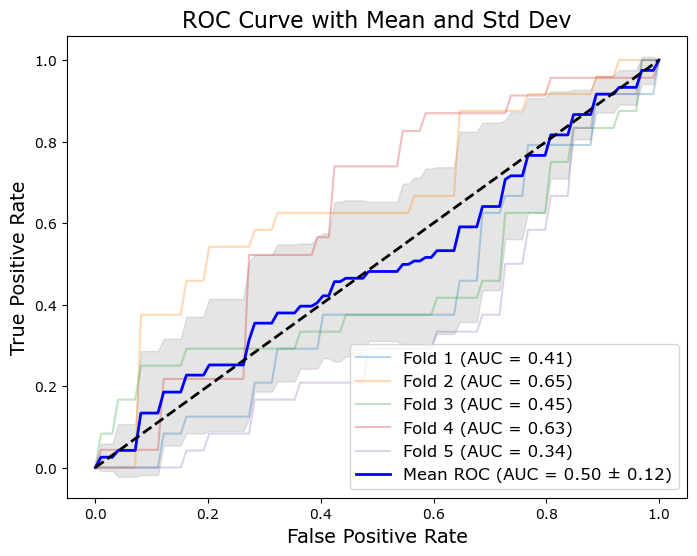

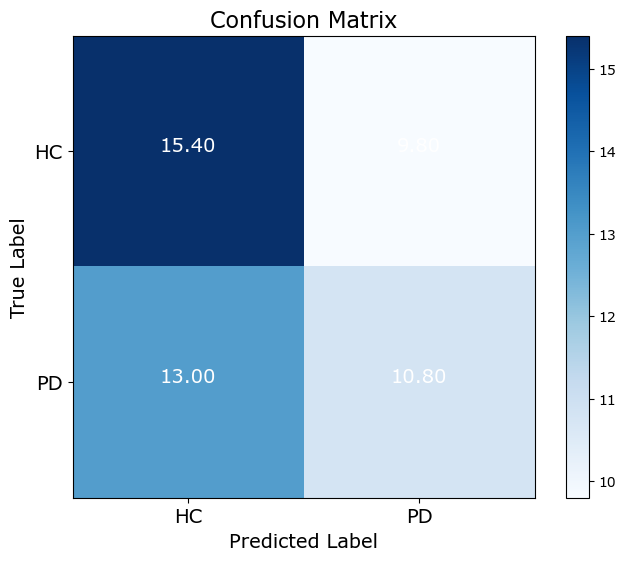

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time
from PIL import Image
import os

# Define the base path for all data folders
data_dir = r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadTextCONVERTED\stft'
hc_folder = os.path.join(data_dir, 'HC')
pd_folder = os.path.join(data_dir, 'PD')

# Function to extract patient ID from filename
def extract_patient_id(filename):
    return filename.split("_")[0]

# Function to load and preprocess image files
def load_image_as_feature(file_path):
    image = Image.open(file_path)
    image = image.resize((128, 128))  # Resize images to a fixed size
    image_array = np.array(image) / 255.0  # Normalize pixel values
    return image_array

# Load file paths and group by patient ID
file_paths = []
labels = []
groups = []

# Load HC files
for filename in os.listdir(hc_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(hc_folder, filename))
        labels.append(0)  # 0 for HC
        groups.append(extract_patient_id(filename))

# Load PD files
for filename in os.listdir(pd_folder):
    if filename.endswith(".png"):
        file_paths.append(os.path.join(pd_folder, filename))
        labels.append(1)  # 1 for PD
        groups.append(extract_patient_id(filename))

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

# Function for speaker-independent evaluation
def speaker_independent_evaluation(file_paths, labels, groups, n_splits=5):
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=n_splits)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': [],
        'fpr': [],
        'tpr': [],
        'roc_auc': [],
        'training_time': [],
        'testing_time': []
    }
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(file_paths, labels, groups), 1):
        print(f"\nFold {fold} - Speaker-Independent Evaluation")
        
        # Split data ensuring no speaker overlap
        X_train, X_val = file_paths[train_idx], file_paths[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]
        
        # Load and preprocess images
        X_train_features = np.array([load_image_as_feature(file) for file in X_train])
        X_val_features = np.array([load_image_as_feature(file) for file in X_val])
        
        # Convert labels to categorical
        y_train = to_categorical(y_train, 2)
        y_val = to_categorical(y_val, 2)
        
        # Build and compile PSFAN model
        input_shape = X_train_features[0].shape
        model = PSFAN(input_shape, num_classes=2)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train model
        start_train = time.time()
        history = model.fit(
            X_train_features, y_train,
            validation_data=(X_val_features, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=0
        )
        training_time = time.time() - start_train
        fold_metrics['training_time'].append(training_time)
        
        # Evaluate model
        start_test = time.time()
        y_pred = model.predict(X_val_features)
        testing_time = time.time() - start_test
        fold_metrics['testing_time'].append(testing_time)
        
        y_true = np.argmax(y_val, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred_labels)
        precision = precision_score(y_true, y_pred_labels, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred_labels, average='weighted')
        f1 = f1_score(y_true, y_pred_labels, average='weighted')
        
        # Store metrics
        fold_metrics['accuracy'].append(accuracy)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1'].append(f1)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_labels)
        fold_metrics['conf_matrix'].append(conf_matrix)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        fold_metrics['fpr'].append(fpr)
        fold_metrics['tpr'].append(tpr)
        fold_metrics['roc_auc'].append(roc_auc)
        
        # Interpolate ROC curve for mean plot
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        plt.plot(mean_fpr, interp_tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')
        
        print(f"Fold {fold} Results: "
              f"Accuracy={accuracy:.2f}, "
              f"Precision={precision:.2f}, "
              f"Recall={recall:.2f}, "
              f"F1={f1:.2f}, "
              f"Training Time={training_time:.2f}s, "
              f"Testing Time={testing_time:.2f}s")
    
    # Calculate mean and standard deviation of metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items() if k not in ['conf_matrix', 'fpr', 'tpr', 'roc_auc']}
    
    print("\nFinal Speaker-Independent Evaluation Metrics:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'training_time', 'testing_time']:
        print(f"{metric.capitalize()}: {mean_metrics[metric]:.2f} ± {std_metrics[metric]:.2f}")
    
    # Plot mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(fold_metrics['roc_auc'])
    
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0),
                     mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with Mean and Std Dev', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot confusion matrix
    mean_conf_matrix = np.mean(fold_metrics['conf_matrix'], axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations
    thresh = mean_conf_matrix.max() / 2.
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, format(mean_conf_matrix[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Run speaker-independent evaluation
speaker_independent_evaluation(file_paths, labels, groups, n_splits=5)